# Setup
Import all modules. Setup pyplot color style and pandas float format.

**Re:** If there is a error with tensorflow's skflow (aka tensorflow learn), check this link: http://stackoverflow.com/questions/37464668/tensorflow-upgrade-failed-on-google-datalab

In [1]:
# Set up
from __future__ import division
import StringIO
import datalab.bigquery as bq
import tensorflow as tf
from tensorflow.contrib import skflow, learn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation, metrics
from sklearn import preprocessing
from datetime import datetime

ImportError: No module named 'StringIO'

In [72]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')

# Load data from bigquery
Prepare and run SQL select query to the GDELT BigQuery table (for more info about GDELT dataset check here: http://gdeltproject.org/data.html#googlebigquery). 

GDELT daaset is quite big, we don't need all of the records and columns. So our select keep only :
* SQLDATE - timestame for event's record
* Actor1Geo_CountryCode - country code where event took place
* QuadClass - describing event "positivness" (1 - material coop, 2 - verbal coop, 3 - verbal cnoflict, 4 - material conflict)
* NumArticles - total sum of number of articles about every event per country per quad class per day

Store query results as pandas DataFrame.

Show descriptive statistics about GDELT dataframe

In [73]:
# Let`s make a connection to the BigQuery

In [74]:
%%sql --module gdelt_query
SELECT Actor1Geo_CountryCode, QuadClass, SQLDATE, SUM(NumArticles) AS NumArticles
FROM [gdelt_tableau.events_protests_country_sample] 
WHERE (Actor1Geo_CountryCode==ActionGeo_CountryCode) AND (DATE(TIMESTAMP(STRING([SQLDATE]))) >= '2000-01-01')
GROUP BY Actor1Geo_CountryCode, QuadClass, SQLDATE  
ORDER BY Actor1Geo_CountryCode, QuadClass, SQLDATE

In [ ]:
# Perform query and run timer
start = datetime.now()
gdelt_df = bq.Query(gdelt_query).to_dataframe()
print('Query done in {}s\n'.format(datetime.now()-start))

In [13]:
# Show descriptive stats
gdelt_df.describe()

QuadClass     SQLDATE  NumArticles
count  111155.00   111155.00    111155.00
mean        2.48 20079496.01      9797.70
std         1.13    47311.33     40398.93
min         1.00 20000101.00         1.00
25%         1.00 20040405.00       117.00
50%         2.00 20080714.00       595.00
75%         3.00 20120701.00      3096.00
max         4.00 20160424.00    896032.00

# (*optional*) Save/load data from local pkl-file
Sometime it is convients to have a saved copy of query result.

Here is two helpers to save/load GDELT dataframe to local pkl-file

In [31]:
# Save dataframe to the file to avoid often queries
gdelt_df.to_pickle('./tf_gdelt_quad_countries_2000_now.pkl')

In [75]:
# Load dataframe from the file
gdelt_df = pd.read_pickle('./tf_gdelt_quad_countries_2000_now.pkl')
print gdelt_df.info()
gdelt_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111155 entries, 0 to 111154
Data columns (total 4 columns):
Actor1Geo_CountryCode    111155 non-null object
QuadClass                111155 non-null int64
SQLDATE                  111155 non-null int64
NumArticles              111155 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.4+ MB
None


QuadClass     SQLDATE  NumArticles
count  111155.00   111155.00    111155.00
mean        2.48 20079496.01      9797.70
std         1.13    47311.33     40398.93
min         1.00 20000101.00         1.00
25%         1.00 20040405.00       117.00
50%         2.00 20080714.00       595.00
75%         3.00 20120701.00      3096.00
max         4.00 20160424.00    896032.00

# Prepare dataset for analysis
Here we are converting SQLDATE string with datetime stamp to datetime index.

Then we are extracting only records for Egypt (country code 'EG'). This will be out dataset for further analysis and machine learning applications 

In [76]:
# We will create new column for datetime series with helper function
def date_from_int(date_int):
  """
  Helper function to convert date from int to datetime object.
  E.g. 20160125 -> 2016-01-25 datetime obj
  """
  date_str = str(date_int)
  date = pd.to_datetime(date_str, format='%Y%m%d')
  return date


# Make a new index with date
gdelt_df['Date'] = gdelt_df['SQLDATE'].apply(date_from_int)
gdelt_df.index = gdelt_df['Date']
gdelt_df.drop(['SQLDATE'], axis=1, inplace=True)

In [77]:
# Prepare dataset  - take events for country EG
def split_events(gdelt_df, measure_name = 'NumArticles', country = 'EG'):
  event_root_codes = gdelt_df.QuadClass.unique()
  event_series = [gdelt_df[(gdelt_df.QuadClass==event_code) & (gdelt_df.Actor1Geo_CountryCode==country)][[measure_name]]
                 for event_code in event_root_codes]
  event_by_codes = pd.concat(event_series, axis=1).sort_index()
  event_by_codes.columns = map(str, event_root_codes)
  event_by_codes = event_by_codes.fillna(method='ffill')
  event_by_codes = event_by_codes.fillna(method='bfill')
  return event_by_codes


event_by_codes = split_events(gdelt_df)

# Data Analysis
Before summon Machine Learning power, we need to understand our dataset.

We already had a look at descriptive statistics, and now it seems interesting to do some basic visualization. 

Let's plot articles number per month per quad class over the time: 

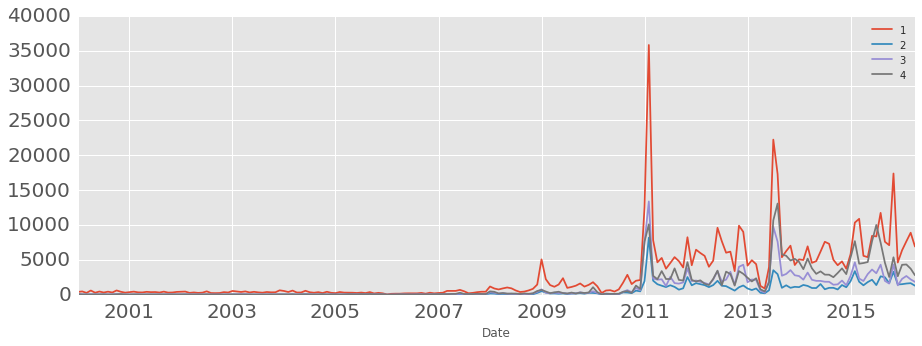

In [78]:
# Plot NumArticle to have a look at the raw data
_ = event_by_codes.resample(rule='1M').mean().plot(figsize=(15, 5), fontsize=20)

**There are several very visible charactersrics of our dataset:**
1. There are much more data after 2010, then before. In order of magnitude.
2. Number of articels for each quad behave in a similar way: in 2011 there is a peak for "Quad Class 1" and there are peaks fol all other classes. Seems like we can try to see if there is a pattern in our dataset.

Really big difference in the numbers over the time can make further analysis difficult. 

We need "normalized" data.

One way to do data normalization is to apply a logarithme function.

**Log function** has 2 advantage:
1. It smooths peak values, and highlights small values
2. It "centralizes" data around zero

Then it is importnat to remeber, that we have events with vector in time. We should **exploit date-time information**.

Let's use time vector to transform our data from raw Number of Articles to the relative Growth Rate. And then normalize Growth Rate with Log function.

For example, in pseudocode our new measure **Growth Rate** will be: 

`Growth_Rate = log( Num_Articles(Day-1) / Number_Arcticles(Day) )`

In [79]:
# Let's use time component and transform data with log
def log_scale_dataframe(df):
  new_df = pd.DataFrame()
  for col in df.columns:
    new_df[col] = np.log(df[col] / df[col].shift() )
  return new_df

event_by_codes_log = log_scale_dataframe(event_by_codes)

Below is a plot of our new dataset.

It is clear that data is centered around zero and have a comparable values.

Machine learning algorithms will work much better on this dataset.

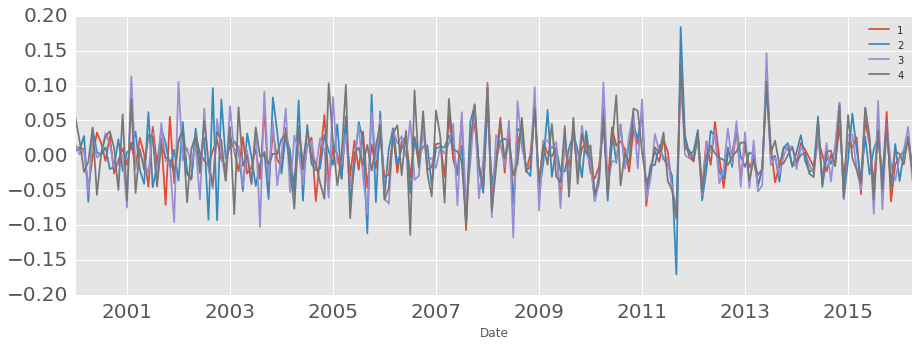

In [80]:
# Plot Growth Rate to have a look at the LOG-normalized data
_ = event_by_codes_log.resample(rule='1M').mean().plot(figsize=(15, 5), fontsize=20)

**It is quite clear now that we have some signal in our data.**

But let's try one more useful and fast visual test to be sure that we are on the right way.

Scatter Matrix allows us to see if there is a correlation between Quad Classes. See more details here: http://www.originlab.com/doc/Tutorials/ScatterMatrix

Scatter plot of perfectly correlated variables will be close to the line, and for the opposite - shapeless cloud.

Our scatter plot matrix shows that all quad classes are correlated and it's a good sign.

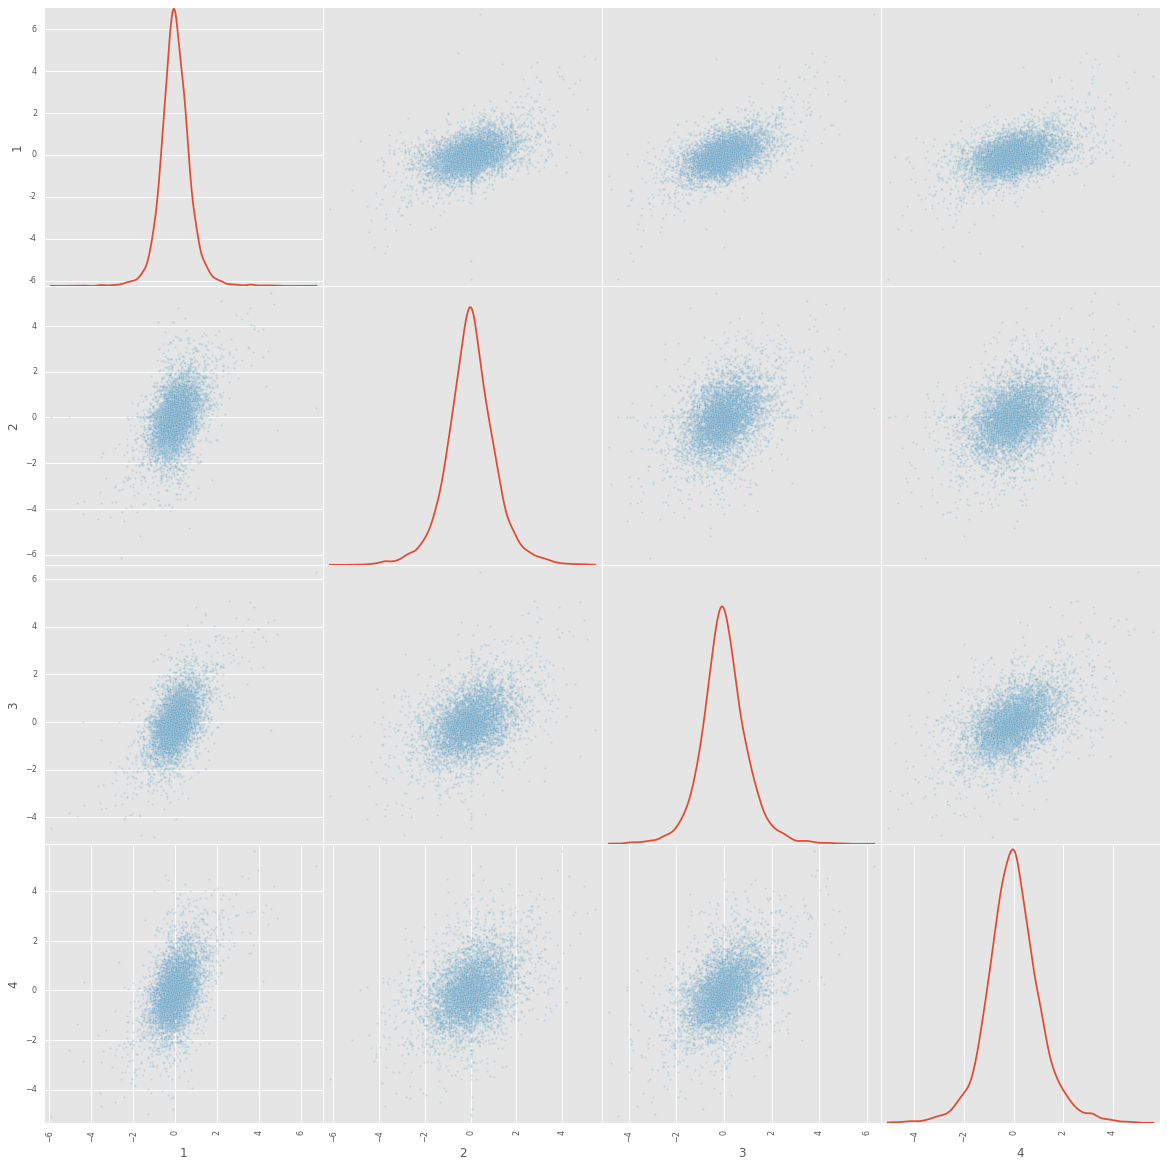

In [81]:
 _ = scatter_matrix(event_by_codes_log, figsize=(20, 20), diagonal='kde', alpha=0.2)

# Recurrent Neural Network in TensorFlow
From our everyday life's experience we know that if there is a buzz in news, it has a tail at leat for several days. 

So let's see if information about the past Growth Rate can help predict the future Growth Rate.

Or, more precisely, let's try to

    predict Material Conflict Growth Rate using information about all 4 quads' Growth Rate from the past.



Reccurent Neural Network shows good perfomance in the tasks where prediction of new value depends in the previous values (more http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

So let's use TensorFlow build-in Datalab to train RNN regression model to predict Material Conflict Growth Rate using information from the last 7 days.  

# Regression Model

In [84]:
# RNN regression
# Prepare X (all quads classes' Growth Rate) and y (Quad Class '4' - Material Conflict real Growth Rate)
X = event_by_codes_log.values
y = event_by_codes_log['4'].shift(periods=-1).values

# There no info from the past for the very first day.
# Let's drop out first day.
X = X[1:-1]
y = y[1:-1]

# Verify that shape of both sets are compatible
print("X shape: {}, y shape: {}".format(X.shape, y.shape)) 

# Split dataset to Train and Test partion in a ratio 80/20. 
# All model training will be done on Train part, and only evalution will be done on Test part. 
test_split = int(0.2 * len(X))
X_train = X[:test_split]
y_train = y[:test_split]
X_test = X[test_split:]
y_test = y[test_split:]

X shape: (5957, 4), y shape: (5957,)


In [85]:
# Helper function to prepare input data for RNN
def rnn_input_fn(x):
  return tf.split(1, 4, x)  # 4 - number of features in X vector

# Validation monitor to do early stopping (https://en.wikipedia.org/wiki/Early_stopping) 
val_monitor = skflow.monitors.ValidationMonitor(X_test, y_test,
                                                early_stopping_rounds=200,
                                                n_classes=0,
                                                print_steps=100)

# RNN Tensorflow regression model
regressor = tf.contrib.learn.TensorFlowRNNRegressor(rnn_size=20,              # How many nodes in a layer (aka cells)
                                                    cell_type="lstm",         # Cell type (lstm has better 'memory', https://en.wikipedia.org/wiki/Long_short-term_memory)
                                                    input_op_fn=rnn_input_fn, # Input data transform function
                                                    num_layers=7,             # How many layers RNN will have (think '# of days in the past RNN will look into')
                                                    steps=1000)               # Max learning steps
# Run model training
regressor.fit(X_train, y_train, monitor=val_monitor)

# Predict Growth Rate values on Test part
y_pred = regressor.predict(X_test)

Step #100, epoch #2, avg. train loss: 0.53959, avg. val loss: 0.50400
Step #200, epoch #5, avg. train loss: 0.51154, avg. val loss: 0.49408
Step #300, epoch #7, avg. train loss: 0.49490, avg. val loss: 0.48978
Step #400, epoch #10, avg. train loss: 0.48722, avg. val loss: 0.49210
Step #500, epoch #13, avg. train loss: 0.47957, avg. val loss: 0.49185


Stopping. Best step:
 step 308 with loss 0.484341025352


MSE: 0.980281257094


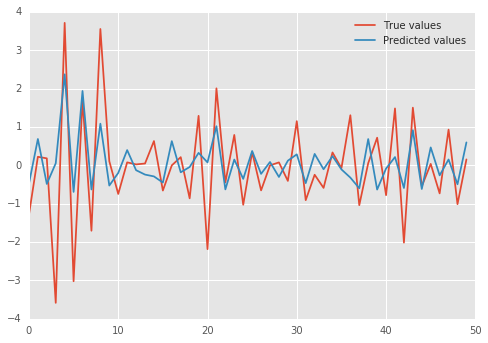

In [92]:
# Plot prediction results and MSE between real Growth Rate of Test part and predictied values
_ = plt.plot(y_test[0:50], label='True values')
_ = plt.plot(y_pred[0:50], label='Predicted values')
plt.legend()
print("MSE: {}".format(metrics.mean_squared_error(y_test, y_pred)))

# Classification Model
Let's try to make a more general prediction. instead of trying to predict actual Growth Rate value, let's predict just Growth direction: 

### Will Growth Rate increase or decrease? 

To do that, we convert Growth Rate to 2 classes: **1 - INCREASE**, **0 - DECREASE** or not changing.

All other steps will be the same as for Regression Model


In [93]:
# RNN Classification
# Helper function to convert Growth Rate value into class
def value_to_class(x):
  if x<=0:
    return 0.0
  else:
    return 1.0

# Prepare X (all quads classes' Growth Rate) and y (Quad Class '4' - Material Conflict Increase/Decrease)
X = event_by_codes_log.values
y = event_by_codes_log['4'].shift(periods=-1)
y = y.apply(value_to_class).values

# There no info from the past for the very first day.
# Let's drop out first day.
X = X[1:-1]
y = y[1:-1]

# Verify that shape of both sets are compatible
print("X shape: {}, y shape: {}".format(X.shape, y.shape)) 

# Split dataset to Train and Test partion in a ratio 80/20. 
# All model training will be done on Train part, and only evalution will be done on Test part.
test_split = int(0.2 * len(X))
X_train = X[:test_split]
y_train = y[:test_split]
X_test = X[test_split:]
y_test = y[test_split:]

X shape: (5957, 4), y shape: (5957,)


In [94]:
# Helper function to prepare input data for RNN
def rnn_input_fn(x):
  return tf.split(1, 4, x)  # 4 - number of features in X vector

# Validation monitor to do early stopping (https://en.wikipedia.org/wiki/Early_stopping)
val_monitor = skflow.monitors.ValidationMonitor(X_test, y_test,
                                                early_stopping_rounds=200,
                                                n_classes=2,
                                                print_steps=100)
# RNN Tensorflow classifier model
classifier = tf.contrib.learn.TensorFlowRNNClassifier(
                rnn_size=20,
                cell_type="lstm",
                n_classes=2,
                input_op_fn=rnn_input_fn,
                num_layers=7,
                steps=1000)

# Run  model training
classifier.fit(X_train, y_train, monitor=val_monitor, logdir='./rnn_clf/')

# Predict Growth Rate class on Test part
y_pred = classifier.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_pred)

Step #100, epoch #2, avg. train loss: 0.66180, avg. val loss: 0.65977
Step #200, epoch #5, avg. train loss: 0.63816, avg. val loss: 0.65059
Step #300, epoch #7, avg. train loss: 0.63640, avg. val loss: 0.64793
Step #400, epoch #10, avg. train loss: 0.63458, avg. val loss: 0.64939
Step #500, epoch #13, avg. train loss: 0.63656, avg. val loss: 0.64875


Stopping. Best step:
 step 313 with loss 0.64524102211


In [96]:
# Measure RNN Classifier performance on Test part (see more: https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing)
print("* Classification report *\n{}".format(
        metrics.classification_report(y_test, 
                                      y_pred)))
print("Accuracy on test set: {:.2f}%".format(
        accuracy_score * 100.0))

* Classification report *
             precision    recall  f1-score   support

        0.0       0.63      0.66      0.65      2497
        1.0       0.61      0.57      0.59      2269

avg / total       0.62      0.62      0.62      4766

Accuracy on test set: 62.17%


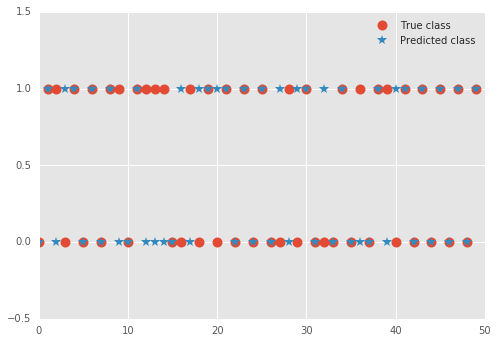

In [97]:
# Plot prediction results and real Growth Rate Class for Test part
plt.ylim(ymin=-0.5, ymax=1.5)
_ = plt.plot(y_test[0:50], 'o', markersize=10, label='True class')
_ = plt.plot(y_pred[0:50], '*', markersize=10, label='Predicted class')
plt.legend()

# Conclusions

* We can tell if Material Conflict will go up or down correctly **6 times out of 10**. Not that bad!
* Classification seems to perform better than regression - it's ok, no one can see the future;)
* Modern state-of-the-art Machine Learning tools are really easy to use with Google Datalab
* Datalab is really integrated into Google Cloud Platfrom ecosystem and especially BigQuery

If you would like to contact me, I'm available on **alexander.usoltsev(at)cirruseo.com**


_______________
(c) 2016, Alexander Usoltsev, Cirruseo (Paris)
